In [1]:
'''
Planner Demo
'''

'\nPlanner Demo\n'

In [2]:
import colors
import cv2 as cv
import hybrid_astar_continuous
# import hybrid_astar_discrete 
import importlib
import math
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import numpy as np
import os
import pickle
import planner_utils as plutils
from start_goal_orientations import orientations
import utils
import warnings

In [3]:
"""
load data
"""

data_path = 'images'

data_list = os.listdir(data_path)
data_list.sort()

fake_B_list = data_list[::3]
real_A_list = data_list[1::3]
real_B_list = data_list[2::3]

# start and goal locations
goal_loc_path = 'goal_points'
goal_name = os.listdir(goal_loc_path)[0]


In [4]:
"""
planning loop
"""
importlib.reload(plutils)
importlib.reload(hybrid_astar_continuous)

# find closest node to the goal
def closest_node(nodes, goal):
    # set nodes to numpy array
    nodes = [list(node) for node in nodes]
    norms = np.linalg.norm(np.asarray(nodes) - np.asarray(goal), axis=1)
    return np.argmin(norms)

def plot_path(map_img, path_coords):
    
    r = 3 # radius of arrow
        
    if path_coords is not None:
        for coord in path_coords:
            col = coord[0]
            row = coord[1]
            theta = coord[2]

            map_img = cv.circle(map_img, (col, row),
                                colors.radius, colors.blue, colors.thickness)

    return map_img
    

# hybrid astar planning loop
def planning_loop_velo(orig_img, start, goal, color_thresh=10, velocity=6.0, kernel_size_d=25, kernel_size_e=20):
    img_coords = plutils.img_coords(orig_img)  # image coords of full image
    road_coords = plutils.get_color_coords_approx(orig_img, img_coords, 
                                                  colors.road_color, thresh=color_thresh)
        
    # map image, binarize road coordinates to black and white image for planning
    map_img = np.zeros((orig_img.shape[0], orig_img.shape[1]))
    plutils.bin_color_coords(map_img, road_coords)  # binarize road coordinates
    
    # dilate and then erode
    kernel = np.ones((kernel_size_d, kernel_size_d), np.uint8)
    dilate_img = cv.dilate(map_img, kernel, iterations=1)

    kernel = np.ones((kernel_size_e, kernel_size_e), np.uint8)
    map_img = cv.erode(dilate_img, kernel, iterations=1)
        
    # broadcast to 3 channels
    map_img = np.repeat(map_img[:, :, np.newaxis], 3, axis=2)  # shape to n x m x 3
    obs_coords = plutils.get_color_coords(map_img, img_coords, colors.black)
    
    # add theta to start and goal
    start = (start[0], start[1], start[2])
    goal = (goal[0], goal[1], goal[2])
    
    hybrid_astar = hybrid_astar_continuous.HybridAstar(map_img, obs_coords, velocity=velocity)
    path_coords = hybrid_astar.find_path(start, goal)
   
    map_img = plot_path(map_img, path_coords)
    return map_img, path_coords

0 10401 10415
we have reached the goal
we have reached the goal


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


we have reached the goal


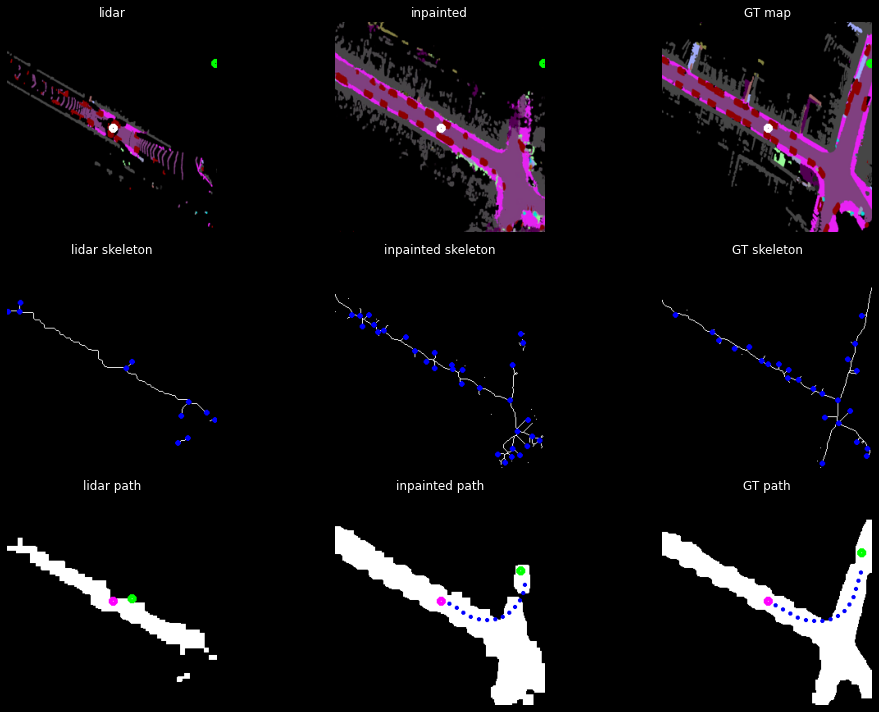

we have reached the goal
we have reached the goal


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


we have reached the goal


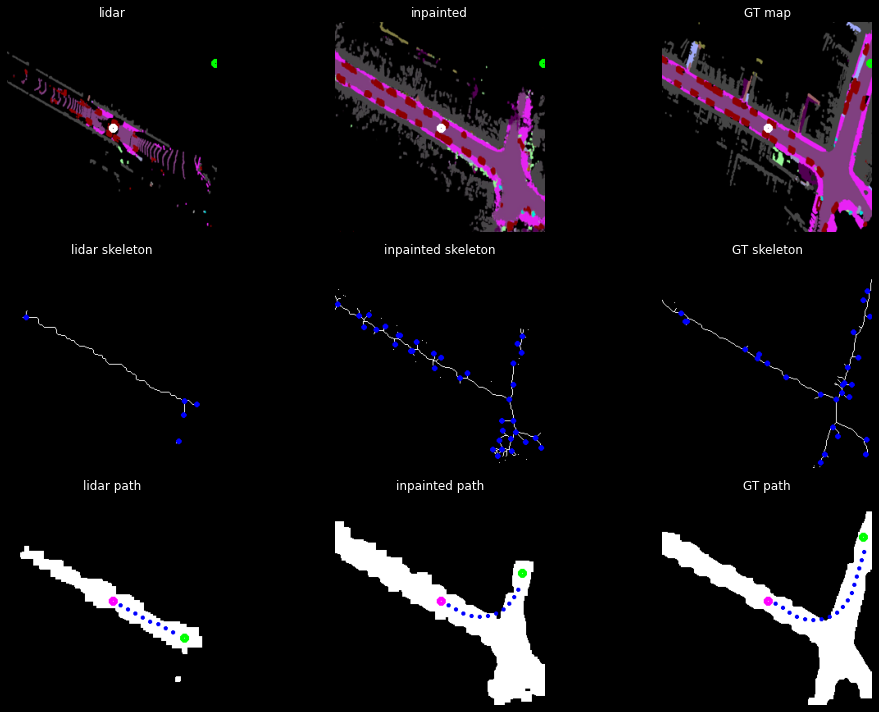

KeyboardInterrupt: 

In [5]:
plt.style.use('dark_background')

seq = int(goal_name[0])
min_frame = int(goal_name[2:7])
max_frame = int(goal_name[8:13])

# get goal locations
goal_points = np.load(os.path.join(goal_loc_path, goal_name))

print(seq, min_frame, max_frame)

real_A_coords_list = []
fake_B_coords_list = []
real_B_coords_list = []

real_A_waypoints_list = []
fake_B_waypoints_list = []
real_B_waypoints_list = []


# iterate over all of the frames
for i, (fake_B_name, real_A_name, real_B_name) in \
        enumerate(zip(fake_B_list, real_A_list, real_B_list)):

    # inpainted image
    fake_B_img = cv.imread(os.path.join(data_path, fake_B_name)) 
    _, fake_B_skeleton, fake_B_waypoints = plutils.get_GT_nodes(fake_B_img, 
                                                      scale_percent=100,
                                                      node_radius=2,
                                                      node_thickness=2,
                                                      color_thresh=10)

    # sparse lidar scan
    real_A_img = cv.imread(os.path.join(data_path, real_A_name)) 
    _, real_A_skeleton, real_A_waypoints = plutils.get_velo_nodes(real_A_img,
                                                        scale_percent=100,
                                                        kernel_size_d=25,
                                                        kernel_size_e=20,
                                                        node_radius=2,
                                                        node_thickness=2,
                                                        color_thresh=20)

    # GT image
    real_B_img = cv.imread(os.path.join(data_path, real_B_name)) 
    # skeletonize and get waypoints
    _, real_B_skeleton, real_B_waypoints = plutils.get_GT_nodes(real_B_img, 
                                                      scale_percent=100,
                                                      node_radius=2,
                                                      node_thickness=2,
                                                      color_thresh=1)

    # goal and start coordinates, in [col, row]
    curr_orientation = orientations[f"{seq}_{min_frame}_{max_frame}"]
    start_coords = [129, 129, curr_orientation[0]]
    goal_coords = goal_points[i]
    goal_coords = [goal_coords[0], goal_coords[1], curr_orientation[1]]

    # plan sparse lidar hybrid astar
    closest_idx = closest_node(real_A_waypoints, [goal_coords[0], goal_coords[1]])
    goal_node1 = real_A_waypoints[closest_idx]
    goal_node1 = [goal_node1[0], goal_node1[1], curr_orientation[1]]
    real_A_path, real_A_coords = planning_loop_velo(real_A_img, start_coords, goal_node1, color_thresh=20, 
                                                    velocity=10.0)

    # plan inpainted hybrid astar
    closest_idx = closest_node(fake_B_waypoints, [goal_coords[0], goal_coords[1]])
    goal_node2 = fake_B_waypoints[closest_idx]    
    goal_node2 = [goal_node2[0], goal_node2[1], curr_orientation[1]]
    fake_B_path, fake_B_coords = planning_loop_velo(fake_B_img, start_coords, goal_node2, 
                                     color_thresh=10, velocity=10.0, kernel_size_d=15, kernel_size_e=0)

    # plan GT hybrid astar
    closest_idx = closest_node(real_B_waypoints, [goal_coords[0], goal_coords[1]])
    goal_node3 = real_B_waypoints[closest_idx] # closest goal node
    goal_node3 = [goal_node3[0], goal_node3[1], curr_orientation[1]]
    real_B_path, real_B_coords = planning_loop_velo(real_B_img, start_coords, goal_node3, 
                                     color_thresh=1, velocity=10.0, kernel_size_d=15, kernel_size_e=0)

    # append to coords list
    real_A_coords_list.append(real_A_coords)
    fake_B_coords_list.append(fake_B_coords)
    real_B_coords_list.append(real_B_coords)

    # append to waypoints
    real_A_waypoints_list.append(real_A_waypoints)
    fake_B_waypoints_list.append(fake_B_waypoints)
    real_B_waypoints_list.append(real_B_waypoints)


    cv.circle(real_A_img, (goal_coords[0], goal_coords[1]), 3, (0, 255, 0), 3)
    cv.circle(real_A_img, (start_coords[0], start_coords[1]), 3, (255, 255, 255), 3)

    cv.circle(real_B_img, (goal_coords[0], goal_coords[1]), 3, (0, 255, 0), 3)
    cv.circle(real_B_img, (start_coords[0], start_coords[1]), 3, (255, 255, 255), 3)

    cv.circle(fake_B_img, (goal_coords[0], goal_coords[1]), 3, (0, 255, 0), 3)
    cv.circle(fake_B_img, (start_coords[0], start_coords[1]), 3, (255, 255, 255), 3)

    cv.circle(real_A_path, (goal_node1[0], goal_node1[1]), 3, (0, 255, 0), 3)
    cv.circle(real_A_path, (start_coords[0], start_coords[1]), 3, (255, 0, 255), 3)

    cv.circle(real_B_path, (goal_node3[0], goal_node3[1]), 3, (0, 255, 0), 3)
    cv.circle(real_B_path, (start_coords[0], start_coords[1]), 3, (255, 0, 255), 3)

    cv.circle(fake_B_path, (goal_node2[0], goal_node2[1]), 3, (0, 255, 0), 3)
    cv.circle(fake_B_path, (start_coords[0], start_coords[1]), 3, (255, 0, 255), 3)

    # plot
    fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(real_A_img)
    ax[0].set_title('lidar')
    ax[0].axis('off')

    ax[1].imshow(fake_B_img)
    ax[1].set_title('inpainted')
    ax[1].axis('off')

    ax[2].imshow(real_B_img)
    ax[2].set_title('GT map')
    ax[2].axis('off')

    ax[3].imshow(real_A_skeleton)
    ax[3].set_title('lidar skeleton')
    ax[3].axis('off')

    ax[4].imshow(fake_B_skeleton)
    ax[4].set_title('inpainted skeleton')
    ax[4].axis('off')

    ax[5].imshow(real_B_skeleton)
    ax[5].set_title('GT skeleton')
    ax[5].axis('off')

    ax[6].imshow(real_A_path)
    ax[6].set_title('lidar path')
    ax[6].axis('off')

    ax[7].imshow(fake_B_path)
    ax[7].set_title('inpainted path')
    ax[7].axis('off')

    ax[8].imshow(real_B_path)
    ax[8].set_title('GT path')
    ax[8].axis('off')


    fig.tight_layout()
    plt.show()
    
